# Analysis and Feature extraction

---

Once the data has been downloaded and preprocessed, the next step is to extract meaningful information from it. This phase is crucial in any remote sensing project, as it transforms raw pixel values into interpretable features for analysis or modeling.

This section introduces common techniques used to extract features from satellite imagery and geospatial data.

---

## Import

In [1]:
from osgeo import gdal,osr,gdalconst
gdal.UseExceptions()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

---

## Classification

### A. Unsupervised classification (KMEANS)

K-Means clustering is an unsupervised machine learning algorithm used to partition data into a predefined number of groups, or clusters, based on similarity. In remote sensing, each pixel can be represented as a vector of spectral values (e.g., reflectance across Sentinel-2 bands), and K-Means groups these pixels into clusters with similar spectral signatures. The algorithm works by initializing a set of centroids, assigning each data point to the nearest centroid, and then updating the centroids as the mean of the assigned points. This process repeats until convergence. The result is a classified image where each pixel belongs to one of the clusters, often representing different land cover types. While K-Means is simple and efficient, it requires the number of clusters to be defined in advance and assumes that clusters are compact and evenly distributed.

Below, we choose the file *S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431* findable on copernicus. Then, we created a smaller image because there was too much ocean part. Finally, we applied the KMEANS.

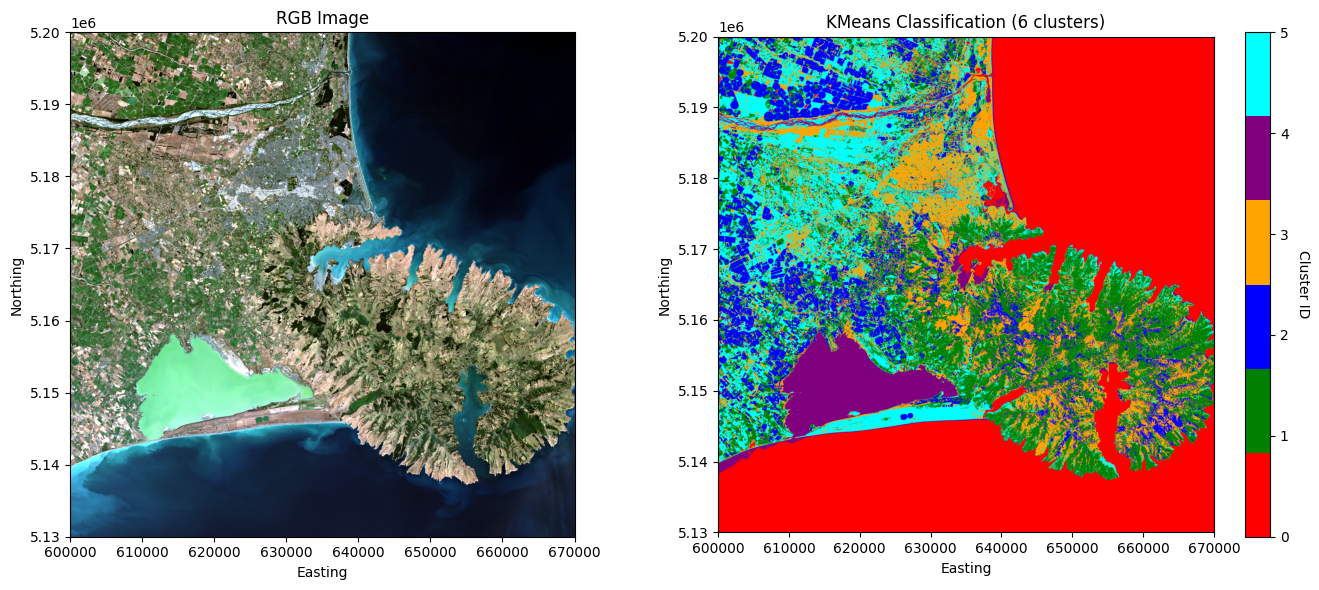

In [ ]:
from sklearn.cluster import KMeans

input_path = "S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif"
scalefactor = 10000 # If you want the true value of reflectance on Sentinel 2 data
n_clusters = 6  # Number of class
patch_size = 3500  # Window size

dataset = gdal.Open(input_path)
n_bands = dataset.RasterCount
gt = dataset.GetGeoTransform()
extent = [gt[0], gt[0] + patch_size * gt[1], gt[3] + patch_size * gt[5], gt[3]]
bands = []
for b in range(1, n_bands + 1):
    band_array = dataset.GetRasterBand(b).ReadAsArray(0, 0, patch_size, patch_size) / scalefactor
    bands.append(band_array)
dataset = None
#KMEANS
data = np.stack(bands, axis=0)  # shape: (bands, rows, cols)
data_2d = data.reshape(n_bands, -1).T  # shape: (n_pixels, n_bands)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(data_2d)
labels = kmeans.labels_.astype(np.uint8)
cluster_image = labels.reshape(patch_size, patch_size)
#RGB
rgb_bands = data[[3, 2, 1], :, :]  # shape: (3, rows, cols)
rgb_image = np.transpose(rgb_bands, (1, 2, 0))
def stretch_percentile(image, lower=2, upper=98):
    p_low = np.percentile(image, lower, axis=(0, 1))
    p_high = np.percentile(image, upper, axis=(0, 1))
    stretched = (image - p_low) / (p_high - p_low)
    return np.clip(stretched, 0, 1)
RGB_stretch=stretch_percentile(rgb_image)
# Colormap
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow', 'pink']
cmap = mcolors.ListedColormap(colors[:n_clusters])
# Display
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(RGB_stretch,extent=extent)
axes[0].set_title('RGB Image')
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")
im = axes[1].imshow(cluster_image, cmap=cmap, extent=extent)
axes[1].set_title(f'KMeans Classification ({n_clusters} clusters)')
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")
cbar = fig.colorbar(im, ax=axes[1], ticks=range(n_clusters))
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

Now what we have the KMEANS, we can display the spectral signal for each KMEANS classes.

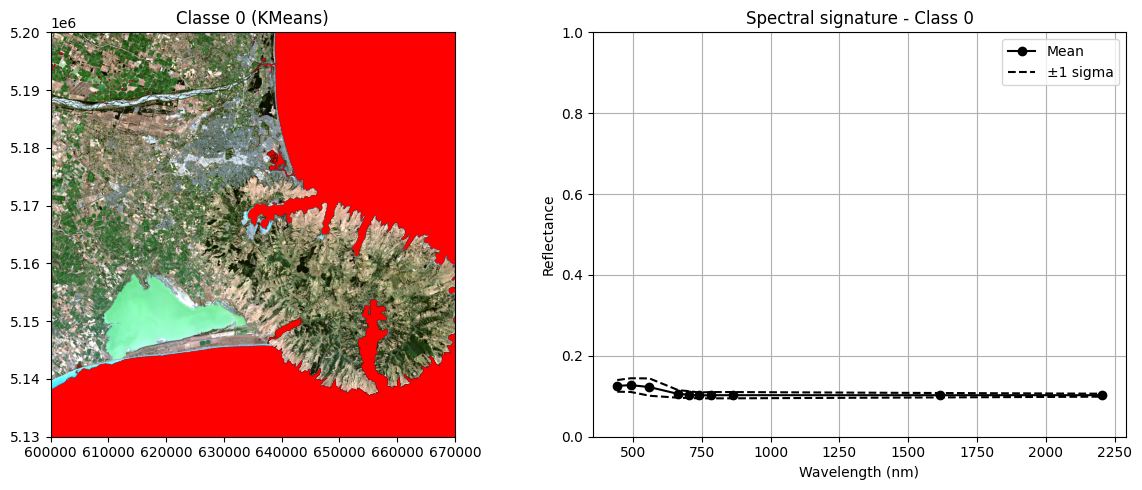

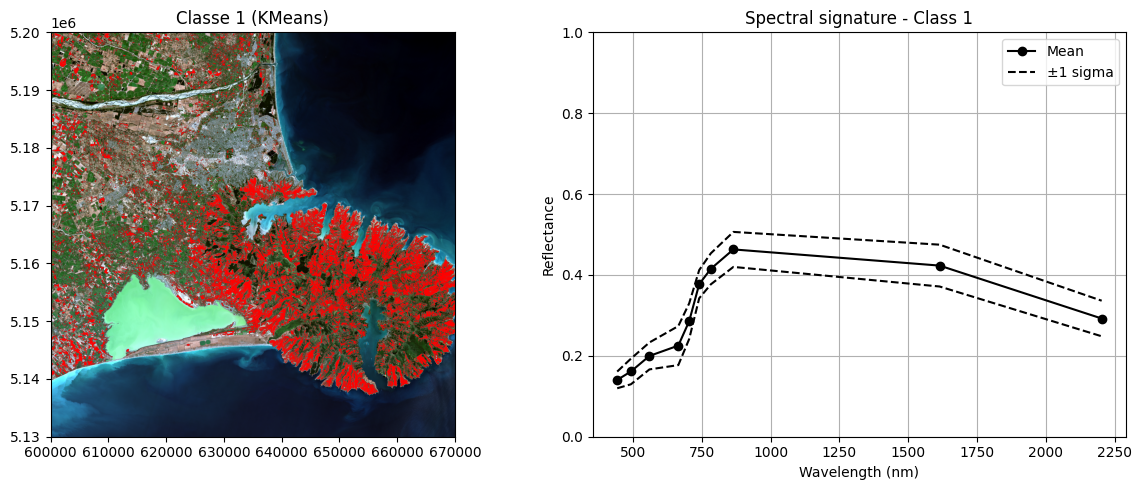

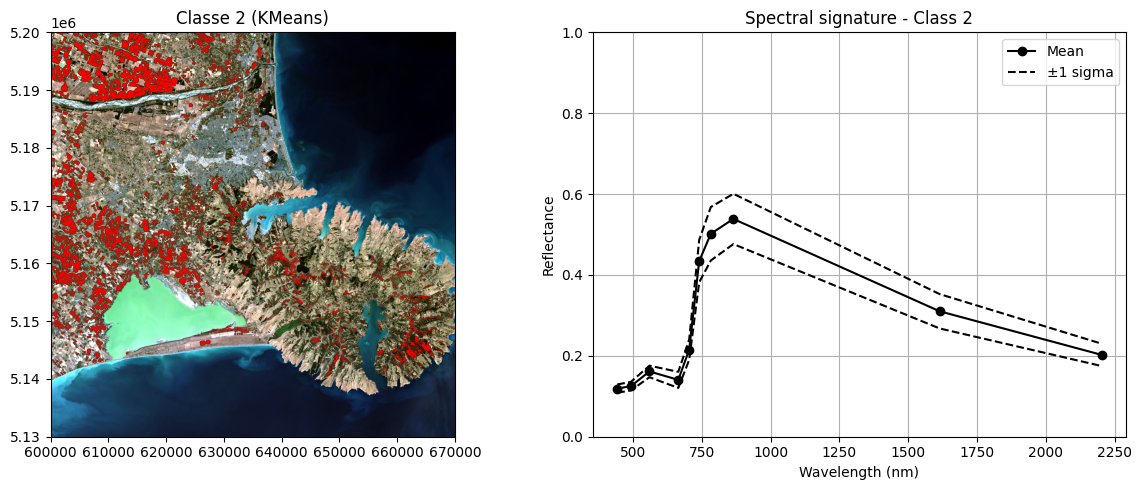

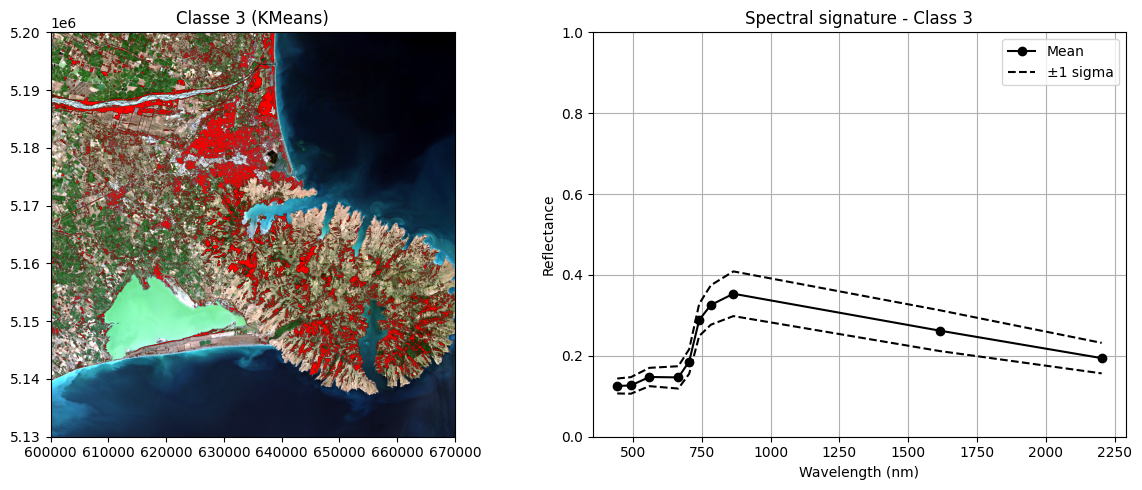

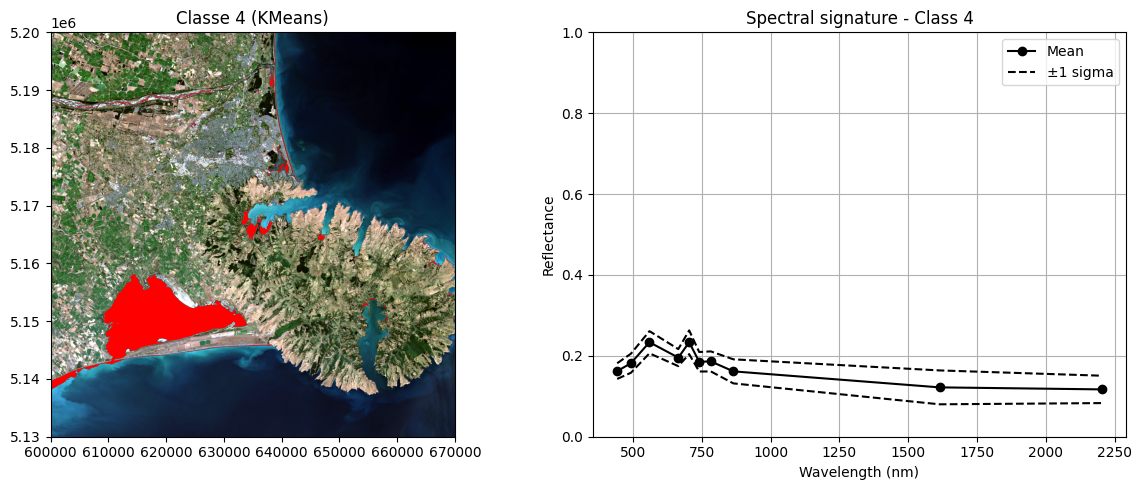

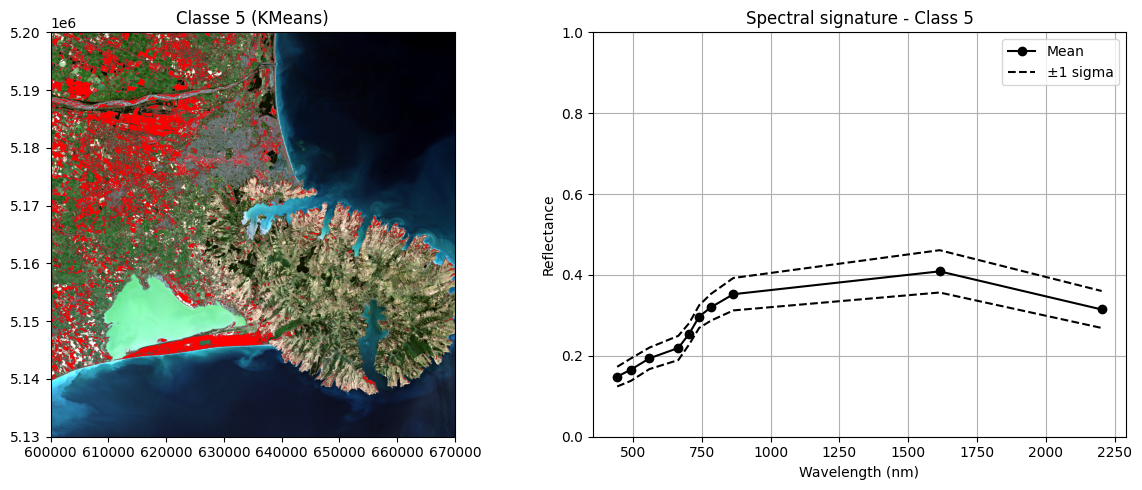

In [ ]:
wvl = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 864.7, 1613.7, 2202.4] #L2A sentinel-2 wavelength (nm)

for i in range(n_clusters):
    mask = (cluster_image == i) # True for pixel in the class = i, false for the other
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Image RGB
    overlay = np.zeros((*mask.shape, 4), dtype=np.float32) # The TRUE Pixel inside the mask become red and the other transparent 
    overlay[mask] = [1, 0, 0, 1]  # Red
    # Display RGB + Red Class Overlay 
    axes[0].imshow(RGB_stretch, extent=extent)
    axes[0].imshow(overlay, extent=extent)
    axes[0].set_title(f'Classe {i} (KMeans)')
    # Mean spectral signature
    mask_3d = mask[np.newaxis, :, :]  # shape (1, rows, cols), make it compatible with the data array
    masked_data = np.where(mask_3d, data, np.nan)  # When pixel inside mask_3d = True, we keep the value in data. The other pixel become Nan
    spectral_signature = np.nanmean(masked_data, axis=(1, 2))  # Mean for each band
    spectral_std = np.nanstd(masked_data, axis=(1, 2)) # Standard deviation for each band
    # Display Spectral signature
    axes[1].plot(wvl, spectral_signature, marker='o', label='Mean', color='k')
    axes[1].plot(wvl, spectral_signature - spectral_std,linestyle='--', label='±1 sigma', color='k')
    axes[1].plot(wvl, spectral_signature + spectral_std,linestyle='--', color='k')
    axes[1].set_title(f'Spectral signature - Class {i}')
    axes[1].set_xlabel('Wavelength (nm)')
    axes[1].set_ylabel('Reflectance')
    axes[1].grid(True)
    axes[1].legend()
    axes[1].set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

We can merge and display all the KMEANS classes in one graph.

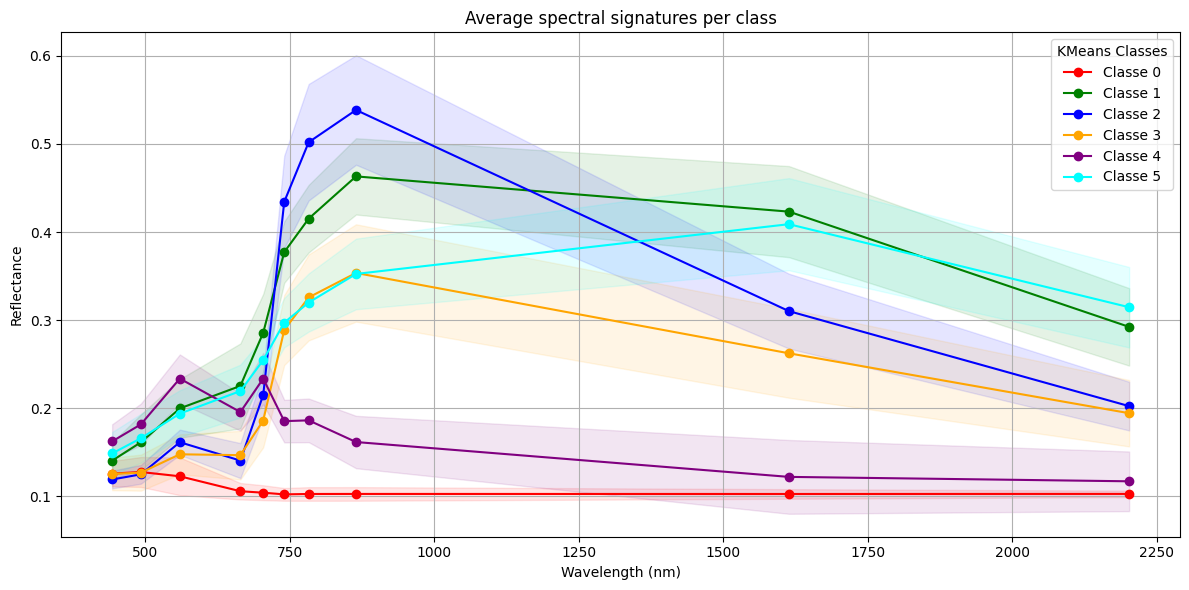

In [10]:
plt.figure(figsize=(12, 6))
for i in range(n_clusters):
    mask = (cluster_image == i)
    mask_3d = mask[np.newaxis, :, :]  # shape: (1, rows, cols)   
    masked_data = np.where(mask_3d, data, np.nan)
    spectral_mean = np.nanmean(masked_data, axis=(1, 2))
    spectral_std = np.nanstd(masked_data, axis=(1, 2))
    color = cmap(i) # The same color as the KMEAN class
    plt.plot(wvl, spectral_mean, marker='o', color=color, label=f'Classe {i}')
    plt.fill_between(wvl, spectral_mean - spectral_std, spectral_mean + spectral_std,color=color, alpha=0.1)
plt.title('Average spectral signatures per class')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True)
plt.legend(title='KMeans Classes')
plt.tight_layout()
plt.show()

### B. Supervised classification (Random Forest)

Random Forest is a powerful and versatile machine learning algorithm used for both classification and regression tasks. It works by building an ensemble of decision trees, each trained on a random subset of the data and features. By aggregating the predictions of these trees (through majority voting for classification or averaging for regression), the algorithm improves accuracy and reduces overfitting compared to individual decision trees. Random Forest is robust to noise, handles high-dimensional data well, and provides insights into feature importance.

#### a. *Data preparation*

Unlike unsupervised methods, supervised classification requires labeled training data. There are several ways to obtain such information. In our case, we will use the [Land Cover Database of New Zealand (LCDB)](https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/) as well as the NDWI index. The LCDB provides different land cover classes, while the NDWI index helps identify water bodies.

Before using these data sources, we need to reproject and clip the shapefile to match the extent and projection of our raster.

In [ ]:
shapefile_in = "lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP/lcdb-v50-land-cover-database-version-50-mainland-new-zealand.shp"
raster_path = "S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif"
shapefile_clipped = "lcdb_v50_final.shp"
# Raster Extent and projection
raster_ds = gdal.Open(raster_path)
gt = raster_ds.GetGeoTransform()
xmin = gt[0]
xmax = xmin + gt[1] * raster_ds.RasterXSize
ymax = gt[3]
ymin = ymax + gt[5] * raster_ds.RasterYSize
srs = osr.SpatialReference()
srs.ImportFromWkt(raster_ds.GetProjection())
epsg_code = srs.GetAttrValue("AUTHORITY", 1)
raster_ds = None
# Step 1 : Reprojection, save in memory
mem_ds = gdal.VectorTranslate(
    destNameOrDestDS="/vsimem/reproj",
    srcDS=shapefile_in,
    options=["-f", "Memory",f"-t_srs", f"EPSG:{epsg_code}"]
)
# Step 2 : Clip to the raster extent
ds=gdal.VectorTranslate(
    destNameOrDestDS=shapefile_clipped,
    srcDS=mem_ds,
    options=["-f", "ESRI Shapefile","-clipsrc", str(xmin), str(ymin), str(xmax), str(ymax),"-overwrite"]
)
ds=None
mem_ds = None

The code below performs the extraction of 100 random sample points for several land cover macro-classes using a vector shapefile (LCDB) and a raster-based water mask derived from the NDWI index. First, the shapefile is loaded and filtered into classes based on land cover codes. For each class, polygons are processed using an R-tree spatial index to efficiently generate random points that fall within the actual geometry. Separately, a Sentinel-2 image is used to compute the NDWI index and identify water pixels. From this water mask, 100 pixel locations are randomly selected and converted to spatial coordinates. Finally, all generated points are visualized on a scatter plot, with different colors representing each class.

Points generated for 'Artificial Surfaces': 1000
Points generated for 'Bare or Lightly-vegetated Surfaces': 1000
Points generated for 'Cropland': 1000
Points generated for 'Grassland, Sedgeland and Marshland': 1000
Points generated for 'Scrub and Shrubland': 1000
Points generated for 'Forest': 1000
Points generated for 'Water': 1000


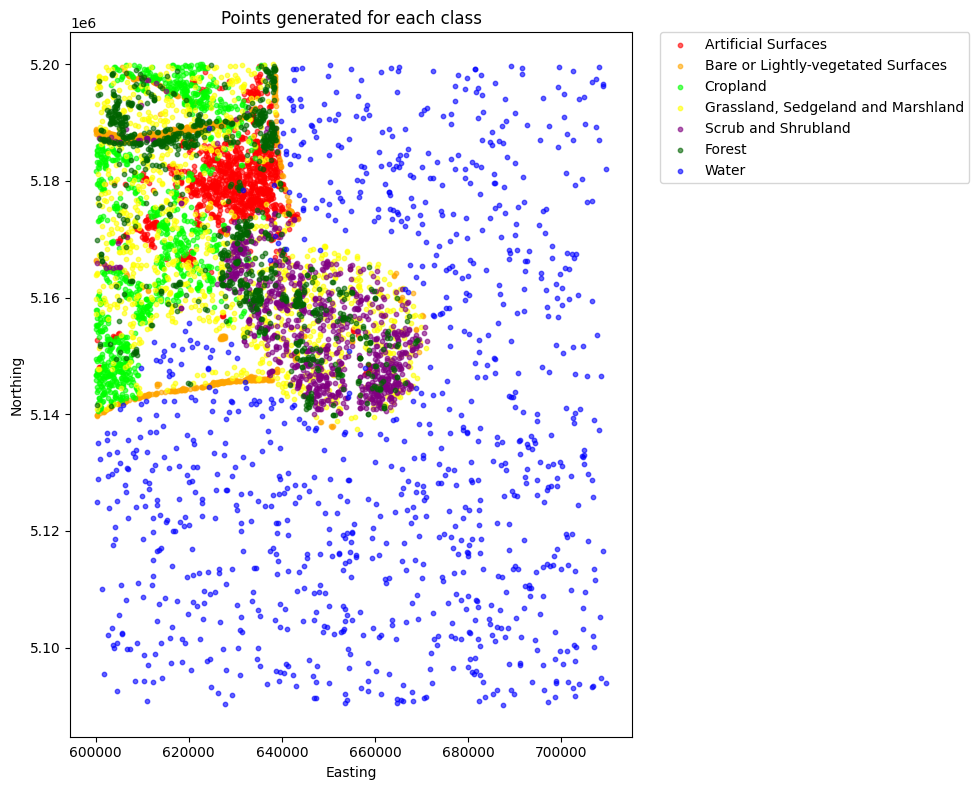

In [3]:
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
from rtree import index

#################################################################################################################################################
### Shapefile ###
gdf = gpd.read_file("lcdb_v50_final.shp")
# Macro-classes et LCDB index
macro_classes = {
    "Artificial Surfaces": [1, 2, 6],
    "Bare or Lightly-vegetated Surfaces": [10, 16, 12, 14, 15],
    "Cropland": [30, 33],
    "Grassland, Sedgeland and Marshland": [40, 41, 43, 44, 45, 46, 47],
    "Scrub and Shrubland": [50, 51, 52, 58, 54, 55, 56, 80, 81],
    "Forest": [71, 64, 68, 69, 70]
}
# Stock polygone in the dictionary
grouped_gdfs = {}
for macro, codes in macro_classes.items():
    grouped_gdfs[macro] = gdf[gdf['Class_2018'].isin(codes)].explode(index_parts=False).reset_index(drop=True) #all layer are convert in polygon and stock in a list
# Create 100 random points
def generate_points(gdf_polygons, n_points, batch_size=1000):
    idx = index.Index() #creation of an rtree index
    for i, geom in enumerate(gdf_polygons.geometry): # we approximate the geometry to a rectangle to reduces the number of polygons to be tested
        idx.insert(i, geom.bounds)
    bounds = gdf_polygons.total_bounds  # the extent of all polygon merged
    points = []
    attempts = 0
    max_attempts = n_points * 1000
    while len(points) < n_points and attempts < max_attempts:
        xs = np.random.uniform(bounds[0], bounds[2], batch_size)
        ys = np.random.uniform(bounds[1], bounds[3], batch_size)
        candidates_points = [Point(x, y) for x, y in zip(xs, ys)]
        for pt in candidates_points:
            if len(points) >= n_points:
                break
            candidate_idx = list(idx.intersection((pt.x, pt.y, pt.x, pt.y))) # fast filtering thanks to rtree index
            if any(gdf_polygons.geometry[i].contains(pt) for i in candidate_idx): # we keep the point when the point is in the reel geometry
                points.append((pt.x, pt.y))
        attempts += batch_size
    return np.array(points)
sample_points = {}
for macro_class, gdf_class in grouped_gdfs.items():
    if len(gdf_class) > 0:
        points = generate_points(gdf_class, 1000)
        sample_points[macro_class] = points
        print(f"Points generated for '{macro_class}': {len(points)}")
    else:
        print(f"No polygon for : {macro_class}")
#################################################################################################################################################
### Raster NDWI ###
path = "S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif"
scalefactor = 10000
dataset = gdal.Open(path)
g = dataset.GetRasterBand(3).ReadAsArray() / scalefactor
nir = dataset.GetRasterBand(8).ReadAsArray() / scalefactor
ndwi = (g - nir) / (nir + g)
veg_mask = ndwi > 0 # equal water class
water_indices = np.argwhere(veg_mask) # return row, col for veg_mask=true so we obtain an array N*2
gt = dataset.GetGeoTransform()
dataset = None
def pixel_to_coords(col, row, gt): # convertion pixel to reel coordinates
    x = gt[0] + col * gt[1] + row * gt[2]
    y = gt[3] + col * gt[4] + row * gt[5]
    return x, y
selected = water_indices[np.random.choice(len(water_indices), 1000, replace=False)] #choose 1000 couple of coordinates
water_points = [pixel_to_coords(col, row, gt) for row, col in selected]
sample_points["Water"] = np.array(water_points)
print("Points generated for 'Water': 1000")
#################################################################################################################################################
### Display ###
colors = {
    "Artificial Surfaces": "red",
    "Bare or Lightly-vegetated Surfaces": "orange",
    "Cropland": "lime",
    "Grassland, Sedgeland and Marshland": "yellow",
    "Scrub and Shrubland": "purple",
    "Forest": "darkgreen",
    "Water":"blue"
}
plt.figure(figsize=(10, 8))
for macro_class, points in sample_points.items():
    if len(points) > 0:
        x_pts, y_pts = points[:, 0], points[:, 1]
        plt.scatter(x_pts, y_pts, s=10, c=colors.get(macro_class, "black"), label=macro_class, alpha=0.6)
plt.title("Points generated for each class")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

The sample have been created. Now, we need to extract the value of the raster depending on the point coordinates. We are going to convert this coordinates to pixel index because we are working with a raster. Afterwards, we create an array of feature and an array of label. This is mandatory for the random forest parameter. Finally, we split the data set into two parts ( train and test).

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

raster_path = "S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif" 
scalefactor = 10000  #If you want the true value of reflectance on Sentinel 2 data
dataset = gdal.Open(raster_path)
n_bands = dataset.RasterCount
gt = dataset.GetGeoTransform()
proj = dataset.GetProjection()
cols = dataset.RasterXSize
rows = dataset.RasterYSize
def coord_to_pixel(x, y, gt): # conversion real coordinate into pixel index
    inv_gt = gdal.InvGeoTransform(gt)
    px, py = gdal.ApplyGeoTransform(inv_gt, x, y)
    return int(px), int(py)
X = [] # Feature
y = [] # Label
for macro_class, points in sample_points.items():
    for x, y_coord in points:
        px, py = coord_to_pixel(x, y_coord, gt) # conversion
        if 0 <= px < cols and 0 <= py < rows: # we check if the index is in the raster limit
            values = []
            for b in range(1, n_bands + 1):
                band = dataset.GetRasterBand(b)
                val = band.ReadAsArray(px, py, 1, 1)[0, 0] / scalefactor # we obtain a scalare not an aray 1*1
                values.append(val)
            if not np.any(np.isnan(values)) and all(0 <= v <= 1 for v in values): # we check if the values is not nan or outside [0-1]
                X.append(values)
                y.append(macro_class)
dataset=None
X = np.array(X)
y = np.array(y)
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y) # Label need to be an int not a string
X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.33, random_state=42) # Split train/test => 33% test and 66% training

#### b. *Random Forest*

The data are prepared. Next, we build a 3D array that stacks all raster bands in the correct shape. Then, we run the Random Forest classifier on the valid pixels. We also create an output array initialized with -1, which represents unclassified pixels.

In [8]:
from sklearn.ensemble import RandomForestClassifier

path = "S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.tif"
scalefactor = 10000
dataset = gdal.Open(path)
n_bands = dataset.RasterCount
cols, rows = dataset.RasterXSize,dataset.RasterYSize
stack = np.empty((rows, cols, n_bands), dtype=np.float32) #empty array
for b in range(n_bands):
    band = dataset.GetRasterBand(b+1).ReadAsArray() / scalefactor
    stack[:, :, b] = band
dataset=None
flat_pixels = stack.reshape(-1, stack.shape[2]) # array (nb_pixel*nb_bands)
valid_mask = ~np.isnan(flat_pixels).any(axis=1) # mask because Random Forest don't accept Nan values
rf_result = np.full((flat_pixels.shape[0],), fill_value=-1, dtype=np.int16) #creation of an array with the shape 1D and fill with -1 (equal unclassified)
clf = RandomForestClassifier(n_estimators=1000, random_state=42) # we choose 1000 tree
clf.fit(X_train, y_train)
rf_result[valid_mask] = clf.predict(flat_pixels[valid_mask])

After reshaping the classification results into a 2D image, it displays the classified raster using a custom colormap.
However, the result is not perfect (for example, scrub and shrubland in purple appears in the ocean). To improve the classification, we could collect more training samples or increase the number of trees in the Random Forest.

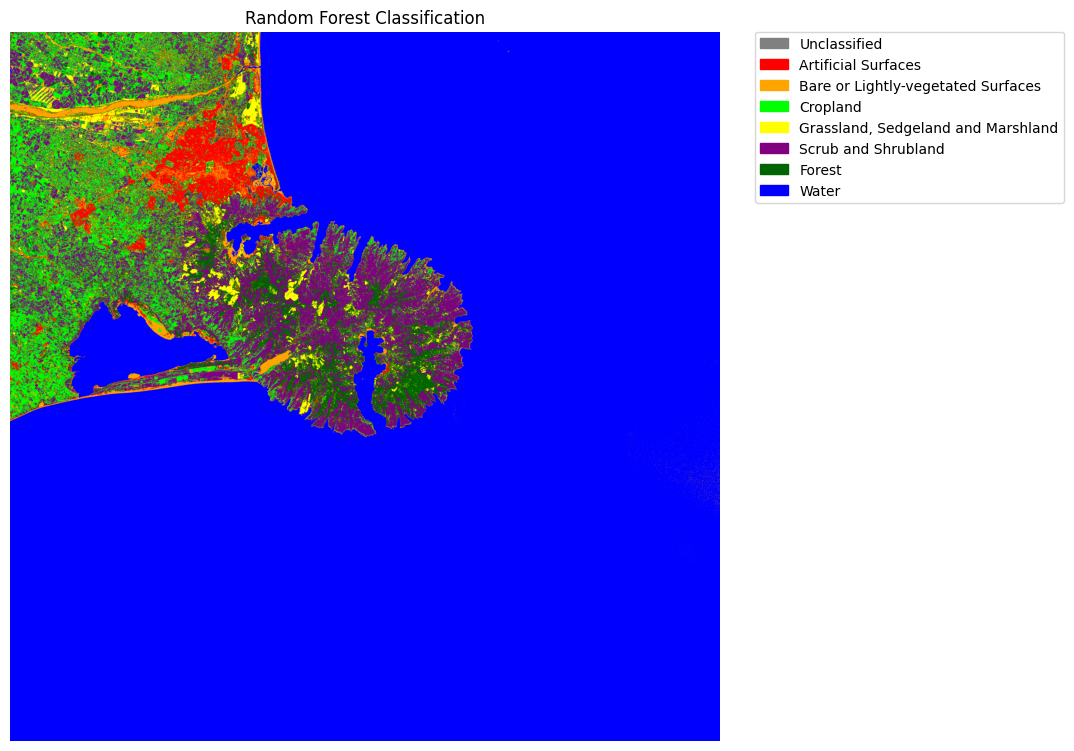

In [9]:
import matplotlib.patches as mpatches
class_info = {
    -1: ("Unclassified", "grey"),
     0: ("Artificial Surfaces", "red"),
     1: ("Bare or Lightly-vegetated Surfaces", "orange"),
     2: ("Cropland", "lime"),
     3: ("Grassland, Sedgeland and Marshland", "yellow"),
     4: ("Scrub and Shrubland", "purple"),
     5: ("Forest", "darkgreen"),
     6: ("Water", "blue")
}
unique_classes = sorted(class_info.keys())
color_list = [class_info[c][1] for c in unique_classes]
label_list = [class_info[c][0] for c in unique_classes]
cmap = mcolors.ListedColormap(color_list)
classified_image = rf_result.reshape(rows, cols) #array (row*col) => array (row,col)
# Display
plt.figure(figsize=(10, 8))
plt.imshow(classified_image, cmap=cmap, vmin=min(unique_classes), vmax=max(unique_classes))
plt.axis('off')
patches = [mpatches.Patch(color=color_list[i], label=label_list[i]) for i in range(len(label_list))] # For the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Random Forest Classification")
plt.tight_layout()
plt.show()

Above, we only see a result but below we will use real evaluation. To do so, we calculate the Cohen’s Kappa, the precision, recall, F1-score, and the confusion matrix to provide a comprehensive evaluation of a classification model. The Kappa index measures the overall agreement between predicted and true labels while accounting for agreement occurring by chance, making it more robust than simple accuracy. The precision indicates how many of the samples predicted as a given class are actually correct, while recall shows how many of the true samples of a class were correctly identified. The F1-score combines precision and recall into a single metric, balancing false positives and false negatives. Finally, the confusion matrix gives a detailed view of misclassifications between all classes, highlighting which classes are most frequently confused, which is essential for diagnosing weaknesses in the model.

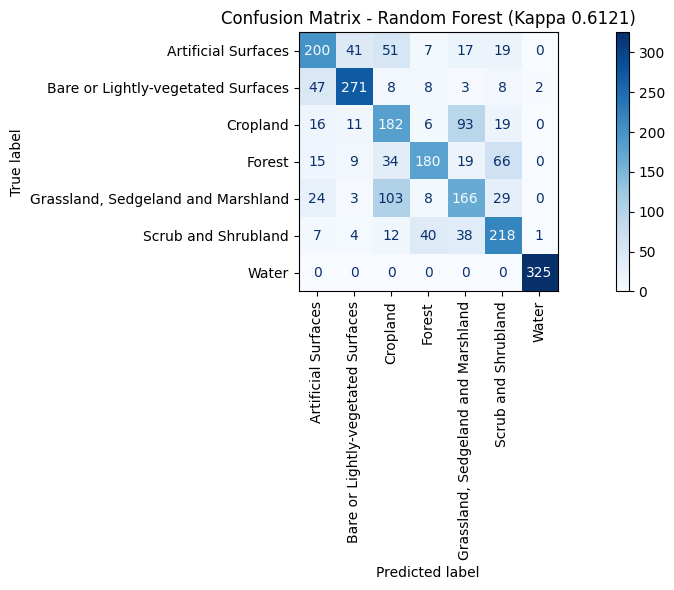

                                    precision    recall  f1-score   support

               Artificial Surfaces       0.65      0.60      0.62       335
Bare or Lightly-vegetated Surfaces       0.80      0.78      0.79       347
                          Cropland       0.47      0.56      0.51       327
                            Forest       0.72      0.56      0.63       323
Grassland, Sedgeland and Marshland       0.49      0.50      0.50       333
               Scrub and Shrubland       0.61      0.68      0.64       320
                             Water       0.99      1.00      1.00       325

                          accuracy                           0.67      2310
                         macro avg       0.68      0.67      0.67      2310
                      weighted avg       0.68      0.67      0.67      2310



In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score,classification_report

y_pred = clf.predict(X_test)
kappa = cohen_kappa_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(12,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
ax.set_title(f"Confusion Matrix - Random Forest (Kappa {kappa:.4f})")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Finally, we save the result in TIFF format because this operation can take a long time, and we don’t want to start over again.

In [11]:
output_path = "rf_classification.tif"

# We open the origin raster to get the projection and geotransform
dataset = gdal.Open(raster_path)
gt = dataset.GetGeoTransform()
proj = dataset.GetProjection()
rows, cols = dataset.RasterYSize, dataset.RasterXSize
dataset = None

# Create the Geotif
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(output_path, cols, rows, 1, gdal.GDT_Int16)
out_ds.SetGeoTransform(gt)
out_ds.SetProjection(proj)
# Write the data
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(classified_image)
out_band.SetNoDataValue(-1) # We set nodata values at -1
out_band.FlushCache()
out_ds = None